In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os

In [3]:
# for curve fitting

from scipy.optimize import curve_fit
#from sklearn import linear_model

def exp_decay(x, a, b, c):
    return a * np.exp(-b * x) + c

def minus_exp_growth(x, a, b, c):
    return c - a * np.exp(b * x) 

def linear(x,m,c): # m = slope, c=intercept
    return m*x+c

In [4]:
cwd=os.getcwd()
path_efficiency=os.path.join(cwd, '../../raw_data/efficiency/')

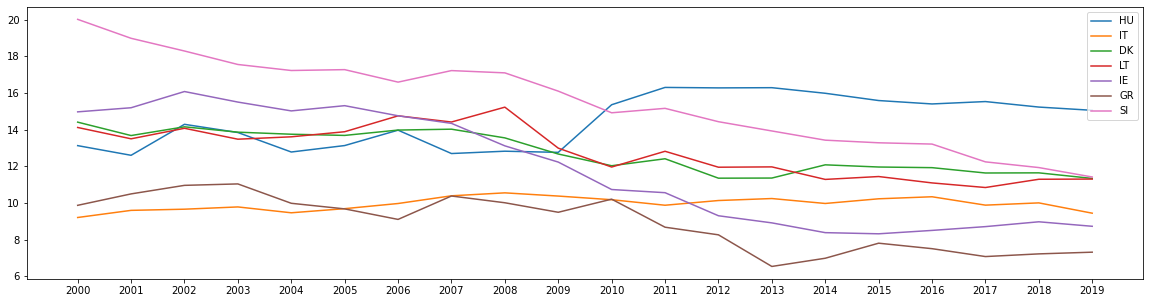

In [5]:
df_ody=pd.read_csv(os.path.join(path_efficiency, 'heating_koe_per_m2.csv'), skiprows=1, index_col=0)

# some countries do not look smooth --> take only second half
plt.figure(figsize=(20,5))
for country in ['HU', 'IT', 'DK', 'LT', 'IE', 'GR', 'SI']:
    plt.plot(df_ody.loc[country], label=country)
plt.legend()
plt.show()

# HU from 2011, LT and IT from 2008, DK, IE, SI from 2007, GR from 2010

In [6]:
# efficiency
# use ODYSSEE unit consumption per m2 in koe/m2 to estimate the efficiency index

# HU from 2011, LT and IT from 2008, DK, IE, SI from 2007, GR from 2010
df_ody.loc['IT', [str(i) for i in np.arange(2000, 2008)]]=np.nan
df_ody.loc['LT', [str(i) for i in np.arange(2000, 2008)]]=np.nan
df_ody.loc['HU', [str(i) for i in np.arange(2000, 2011)]]=np.nan
df_ody.loc['DK', [str(i) for i in np.arange(2000, 2007)]]=np.nan
df_ody.loc['IE', [str(i) for i in np.arange(2000, 2007)]]=np.nan
df_ody.loc['SI', [str(i) for i in np.arange(2000, 2007)]]=np.nan
df_ody.loc['GR', [str(i) for i in np.arange(2000, 2010)]]=np.nan


df_eff_idx=df_ody.copy()
# add 2020
df_eff_idx[['2020', '2021', '2022']]=np.nan

x_all=np.linspace(0,19,20)

dict_eff_model_params={}
dict_eff_model_cov={}
dict_eff_error={}

# take moving average and fit curve
for i in range(len(df_eff_idx)):

    _v_all=df_ody.iloc[i].values.copy()
    
    # exclude nan's in the model   
    _v=_v_all[~np.isnan(_v_all)]
    _x=x_all[~np.isnan(_v_all)]

    # if _v_all starts with nan
    if np.isnan(_v_all[0]):
        _model_x_start=np.argwhere(~np.isnan(_v_all)).ravel()[0]
    # otherwise nan's are at the end    
    else:
        _model_x_start=0
        
            
    # 3-step moving average; 2-step t +/- 1 at endpoints 
    _v_ave=np.array([_v[ max(0,i-1) : min(i+2, len(_v))].mean() for i in range(len(_v))])
    
    
    # extend HU model from 2010
    if df_eff_idx.index[i]=='HU':
        _predict_x=np.arange(10,23)
        _model_x_start=10 # extrapolate to 2010
    else:
        _predict_x=np.arange(_model_x_start,23)
    
    #print(_x)
    #print(_v_ave)
    try: # first try exponential decay
        popt, pcov = curve_fit(exp_decay, _x, _v_ave, bounds=([0,0,-np.inf], np.inf), absolute_sigma=True)
        #print(popt)
        _z= exp_decay(_predict_x, *popt)
        dict_eff_model_params[df_eff_idx.index[i]]=['exponential decay', popt]
        dict_eff_model_cov[df_eff_idx.index[i]]=['exponential decay', pcov]
        
        print(df_eff_idx.index[i], 'exponential decay', popt)
   
    except: 
        try: # then try minus exponential growth
            popt, pcov = curve_fit(minus_exp_growth, _x, _v_ave, bounds=([0,0,-np.inf], np.inf))
            _z= minus_exp_growth(_predict_x, *popt)
            dict_eff_model_params[df_eff_idx.index[i]]=['minus exponential growth', popt]
            dict_eff_model_cov[df_eff_idx.index[i]]=['minus exponential growth', pcov]

            print(df_eff_idx.index[i], 'minus exponential growth', popt)

        except:  # finally try linear model
            try:
                #regr = linear_model.LinearRegression()
                #regr.fit(_x.reshape(-1,1), _v_ave)
                #_z = regr.predict(_predict_x.reshape(-1,1))
                #dict_eff_model_params[df_eff_idx.index[i]]=['linear', [regr.coef_[0], regr.intercept_]]
                
                popt, pcov = curve_fit(linear, _x, _v_ave, bounds=([-np.inf,0], [0, np.inf]))
                _z= linear(_predict_x, *popt)
                dict_eff_model_params[df_eff_idx.index[i]]=['linear', popt]
                dict_eff_model_cov[df_eff_idx.index[i]]=['linear', pcov]

                print(df_eff_idx.index[i], 'linear', popt)
                
                
            except:
                _z =np.append(_v_ave, np.nan)
                print(df_eff_idx.index[i], 'no suitable model')
                
   
    if _model_x_start==0:  
        df_eff_idx.iloc[i]=_z
    else:
        df_eff_idx.iloc[i]=np.append(np.repeat(np.nan, _model_x_start), _z)
        
    # residual standard error (scaled to mean consumption)
    l=len(_v)
    if df_eff_idx.index[i]=='HU':
        s= np.sqrt(((_z[1:l+1]-_v)**2).sum()/l)/(_v.mean()) # shift forward by 1 year for HU
    else:        
        s= np.sqrt(((_z[:l]-_v)**2).sum()/l)/(_v.mean())
    dict_eff_error[df_eff_idx.index[i]]=s
    

# use 2010 as base
base_year='2020'
df_eff_idx = df_eff_idx.apply(lambda x: x/x[base_year], axis=1)


df_eff_idx

AT exponential decay [ 4.29867932  0.21631915 13.69123359]
BG exponential decay [0.60645051 0.05449008 6.80313524]
HR minus exponential growth [ 4.74708781  0.03448717 21.87148116]
CY exponential decay [2.40494172 0.18443084 2.034143  ]
CZ exponential decay [ 5.58800608  0.09663855 13.71143934]
DK exponential decay [34.19085491  0.38343726 11.5859293 ]
EE exponential decay [8.61918264 0.02226936 8.46807145]
FI minus exponential growth [ 0.07218693  0.18238434 13.65793694]
FR exponential decay [7.32095125 0.06553297 7.93883198]
DE exponential decay [7.53036343 0.10803533 9.59679726]
GR exponential decay [8.93165800e+02 5.90704313e-01 7.18667050e+00]
HU linear [-0.16125555 18.15598146]
IE exponential decay [40.43619222  0.27064617  8.13200525]
IT minus exponential growth [2.47686453e-03 2.84973458e-01 1.02847447e+01]
LV exponential decay [20.91256524  0.03860991  4.22166674]
LT exponential decay [30.76676247  0.2846848  10.95287847]
LU exponential decay [47.9846859   0.32729801 15.148160

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
AT,1.308544,1.247721,1.198730,1.159269,1.127484,1.101882,1.081260,1.064649,1.051270,1.040493,...,1.014652,1.010998,1.008055,1.005684,1.003775,1.002237,1.000998,1.0,0.999196,0.998549
BG,1.057444,1.052854,1.048507,1.044391,1.040494,1.036803,1.033308,1.029998,1.026863,1.023895,...,1.013516,1.011255,1.009115,1.007088,1.005169,1.003351,1.001630,1.0,0.998457,0.996995
HR,1.379935,1.366512,1.352619,1.338237,1.323352,1.307944,1.291995,1.275486,1.258399,1.240712,...,1.163535,1.142519,1.120766,1.098249,1.074943,1.050818,1.025847,1.0,0.973246,0.945553
CY,2.119621,1.926215,1.765383,1.631639,1.520420,1.427933,1.351023,1.287067,1.233882,1.189654,...,1.075709,1.058122,1.043496,1.031334,1.021220,1.012810,1.005816,1.0,0.995164,0.991142
CZ,1.329137,1.293687,1.261502,1.232283,1.205754,1.181670,1.159804,1.139952,1.121929,1.105566,...,1.053862,1.043769,1.034606,1.026287,1.018734,1.011877,1.005652,1.0,0.994869,0.990210
DK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.199860,1.135769,1.092090,...,1.018786,1.012365,1.007988,1.005006,1.002973,1.001588,1.000643,1.0,0.999561,0.999263
EE,1.221450,1.207881,1.194611,1.181633,1.168941,1.156528,1.144389,1.132517,1.120907,1.109552,...,1.066579,1.056420,1.046486,1.036770,1.027268,1.017976,1.008888,1.0,0.991308,0.982807
FI,1.247889,1.246562,1.244970,1.243060,1.240767,1.238015,1.234713,1.230751,1.225995,1.220288,...,1.183519,1.169314,1.152266,1.131808,1.107256,1.077792,1.042433,1.0,0.949077,0.887965
FR,1.539391,1.492545,1.448670,1.407578,1.369093,1.333049,1.299292,1.267675,1.238064,1.210332,...,1.115912,1.095927,1.077211,1.059682,1.043264,1.027888,1.013487,1.0,0.987368,0.975538
DE,1.636672,1.562982,1.496838,1.437468,1.384177,1.336343,1.293408,1.254869,1.220277,1.189228,...,1.093733,1.075642,1.059403,1.044828,1.031745,1.020002,1.009461,1.0,0.991508,0.983885


In [7]:
dict_eff_error

{'AT': 0.0210474155331038,
 'BG': 0.043838217702105116,
 'HR': 0.020131341810318285,
 'CY': 0.13462553565553215,
 'CZ': 0.031099432401312313,
 'DK': 0.025137483883653035,
 'EE': 0.04233193178145918,
 'FI': 0.016941623367383682,
 'FR': 0.014337716584769396,
 'DE': 0.04333345691580156,
 'GR': 0.059509548730827526,
 'HU': 0.007856326999086175,
 'IE': 0.03991549964693211,
 'IT': 0.01972833311496844,
 'LV': 0.05089896693271264,
 'LT': 0.03869349573040841,
 'LU': 0.05944438143222304,
 'NL': 0.027410668620554104,
 'PL': 0.039715267503753156,
 'PT': 0.14287170947833824,
 'RO': 0.07120610441111609,
 'SK': 0.05401090467007737,
 'SI': 0.01914857271524244,
 'ES': 0.07275413873822985,
 'SE': 0.04638600774266778,
 'CH': 0.021175966932845937,
 'GB': 0.031720564761118314,
 'EU': 0.01993832141176818,
 'EU28': 0.01784027835042101}

In [8]:
# check monotonicity

(df_eff_idx.diff(axis=1)>0).any(axis=1)

AT      False
BG      False
HR      False
CY      False
CZ      False
DK      False
EE      False
FI      False
FR      False
DE      False
GR      False
HU      False
IE      False
IT      False
LV      False
LT      False
LU      False
NL      False
PL      False
PT      False
RO      False
SK      False
SI      False
ES      False
SE      False
CH      False
GB      False
EU      False
EU28    False
dtype: bool

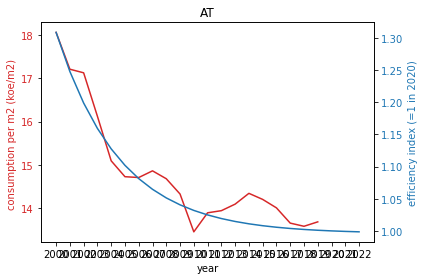

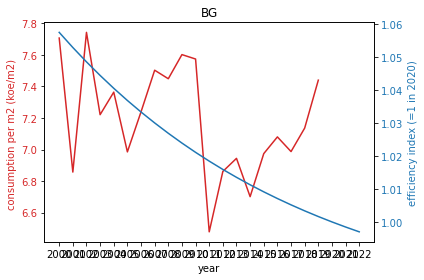

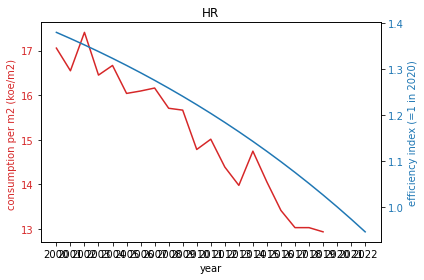

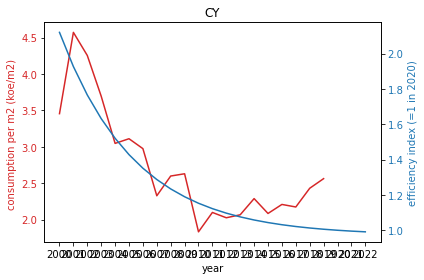

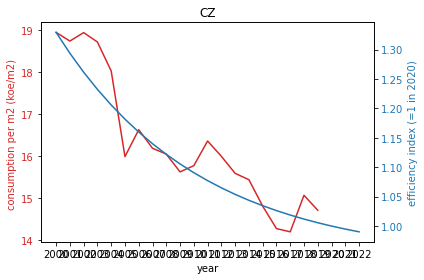

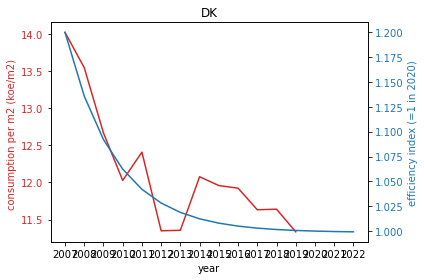

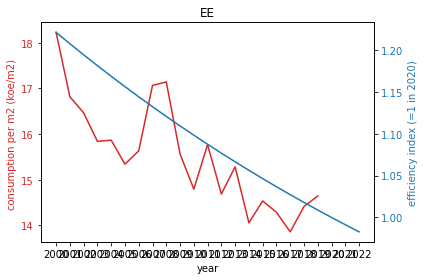

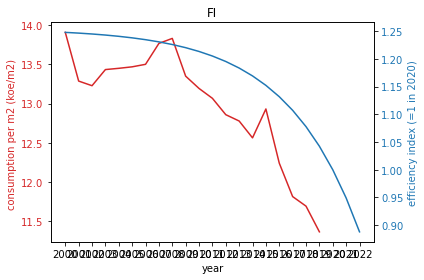

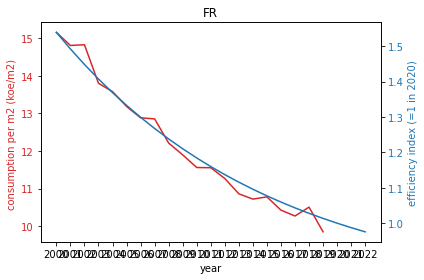

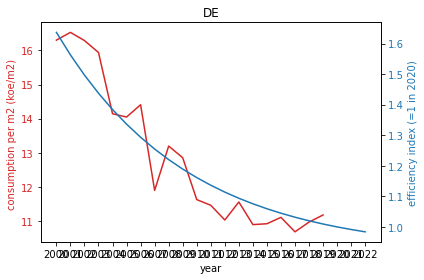

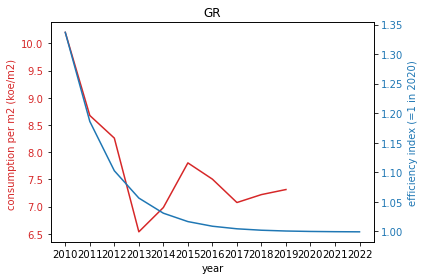

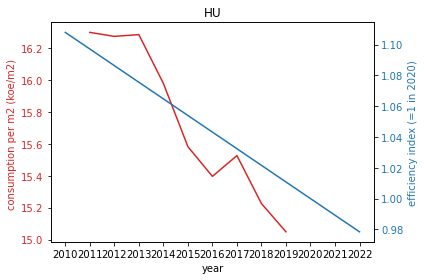

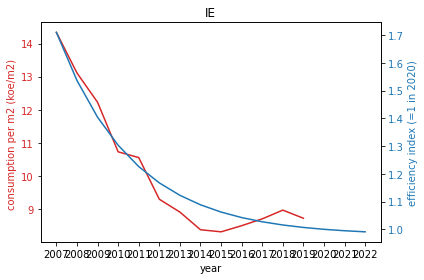

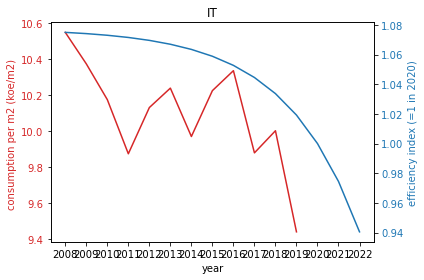

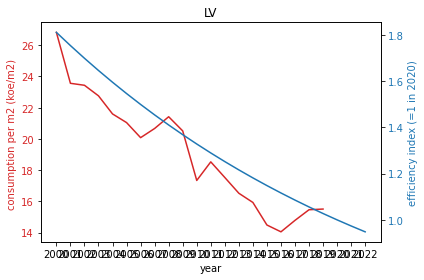

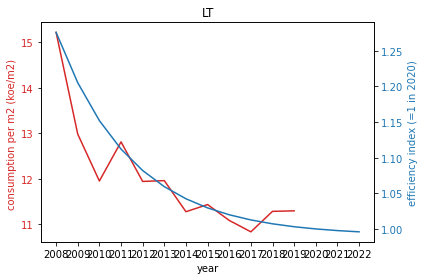

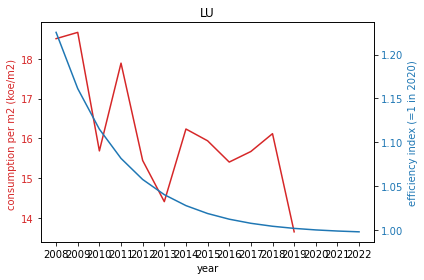

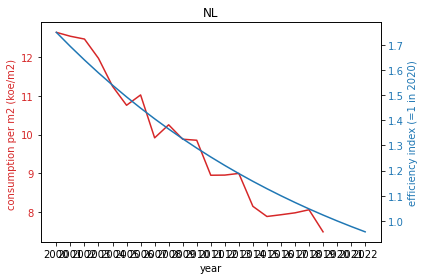

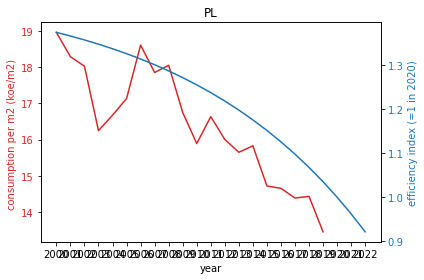

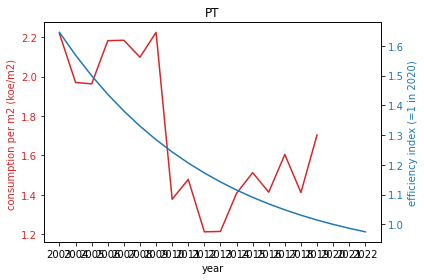

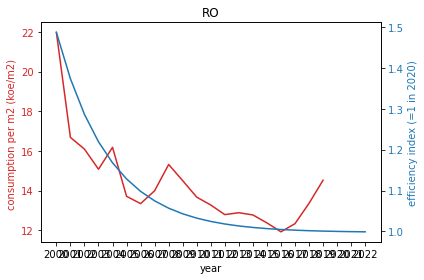

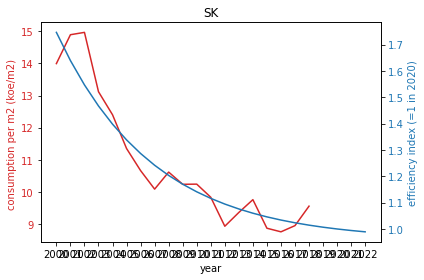

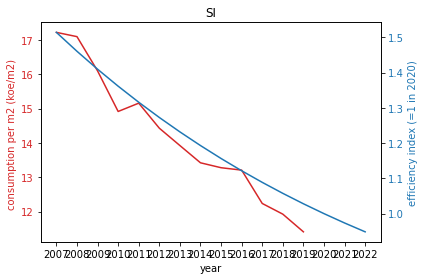

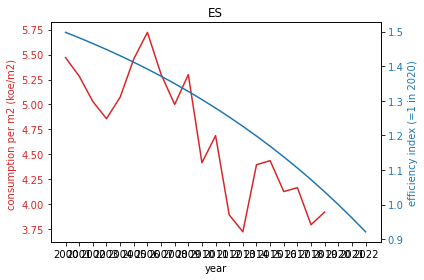

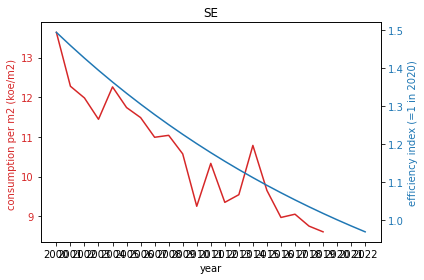

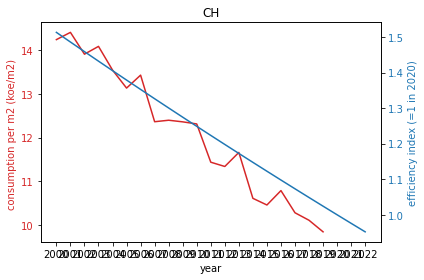

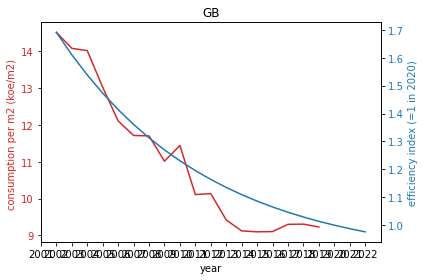

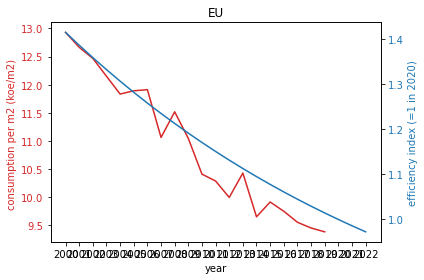

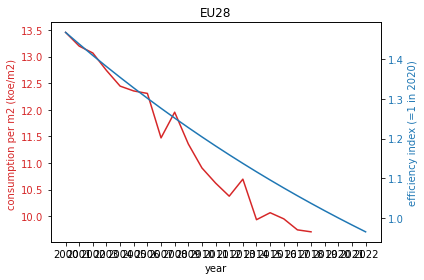

In [9]:
# check
# allow shift in the y-axes (y-ticks are not aligned in any way)
for country in df_eff_idx.index:
    if country in df_ody.index:

        t=list(df_ody.columns)
        data1=df_ody.loc[country].values
        data2=df_eff_idx.loc[country]

        fig, ax1 = plt.subplots()

        color = 'tab:red'
        ax1.set_xlabel('year')
        #ax1.set_xticks(np.arange(int(t[0]), int(t[-1]), 2))
        ax1.set_ylabel('consumption per m2 (koe/m2) ', color=color)
        ax1.plot(t, data1, color=color)
        ax1.tick_params(axis='y', labelcolor=color)

        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

        color = 'tab:blue'
        ax2.set_ylabel('efficiency index (=1 in 2020)', color=color)  # we already handled the x-label with ax1
        ax2.plot(t+[2020, 2021, 2022], data2, color=color)
        ax2.tick_params(axis='y', labelcolor=color)

        ax1.set_title(country)

        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        plt.show()

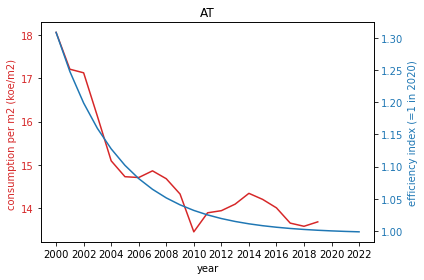

In [10]:
# output AT model plot
country='AT'

t=np.array([int(y) for y in list(df_ody.columns)])
t_ext=np.append(t, np.array([2020, 2021, 2022]))
data1=df_ody.loc[country].values
data2=df_eff_idx.loc[country]

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('year')
ax1.set_xticks(t_ext[::2])
ax1.set_ylabel('consumption per m2 (koe/m2) ', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('efficiency index (=1 in 2020)', color=color)  # we already handled the x-label with ax1
ax2.plot(t_ext, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax1.set_title(country)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('efficiency_index_AT.png', dpi=300)
plt.show()


In [11]:
# compare with export_enerdata_1160584_013419.xlsx
df_eff_idx['2011']/df_eff_idx['2000']

AT      0.783176
BG      0.963099
HR      0.872109
CY      0.529478
CZ      0.810468
DK           NaN
EE      0.890406
FI      0.965807
FR      0.753566
DE      0.694300
GR           NaN
HU           NaN
IE           NaN
IT           NaN
LV      0.712083
LT           NaN
LU           NaN
NL      0.716691
PL      0.900516
PT           NaN
RO      0.688943
SK      0.639017
SI           NaN
ES      0.853862
SE      0.787482
CH      0.808465
GB           NaN
EU      0.813348
EU28    0.804937
dtype: float64

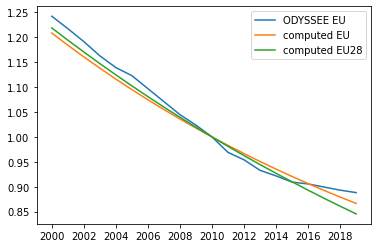

In [12]:
# compare with EU_efficiency.csv
df_EU_eff=pd.read_csv(os.path.join(path_efficiency, 'EU_efficiency.csv'), skiprows=1, index_col=0)
df_EU_eff=df_EU_eff[['index']]
plt.plot(df_EU_eff.loc[2000:]/df_EU_eff.loc[2010].values, label='ODYSSEE EU')
plt.plot(df_EU_eff.loc[2000:].index, df_eff_idx.loc['EU'].values[:-3]/df_eff_idx.loc['EU', '2010'], label='computed EU')
plt.plot(df_EU_eff.loc[2000:].index, df_eff_idx.loc['EU28'].values[:-3]/df_eff_idx.loc['EU28', '2010'], label='computed EU28')
plt.xticks(np.arange(2000, 2020, 2))
plt.legend()
plt.show()

In [13]:
# check
country='GB'
print(dict_eff_model_params[country])
print(dict_eff_model_cov[country])
print(dict_eff_error[country])

['exponential decay', array([8.77727284, 0.10319199, 7.60821389])]
['exponential decay', array([[ 1.86210578e+00, -4.42857404e-02, -1.91453776e+00],
       [-4.42857404e-02,  3.86064181e-03,  1.20979464e-01],
       [-1.91453776e+00,  1.20979464e-01,  4.05156807e+00]])]
0.031720564761118314


In [14]:
# use EU average (more conservative, less steep than EU28) for NO, BE and UA
df_eff_idx.loc['NO']=df_eff_idx.loc['EU'].values
df_eff_idx.loc['BE']=df_eff_idx.loc['EU'].values
df_eff_idx.loc['UA']=df_eff_idx.loc['EU'].values
df_eff_idx.columns=df_eff_idx.columns.astype(int)
df_eff_idx

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
AT,1.308544,1.247721,1.198730,1.159269,1.127484,1.101882,1.081260,1.064649,1.051270,1.040493,...,1.014652,1.010998,1.008055,1.005684,1.003775,1.002237,1.000998,1.0,0.999196,0.998549
BG,1.057444,1.052854,1.048507,1.044391,1.040494,1.036803,1.033308,1.029998,1.026863,1.023895,...,1.013516,1.011255,1.009115,1.007088,1.005169,1.003351,1.001630,1.0,0.998457,0.996995
HR,1.379935,1.366512,1.352619,1.338237,1.323352,1.307944,1.291995,1.275486,1.258399,1.240712,...,1.163535,1.142519,1.120766,1.098249,1.074943,1.050818,1.025847,1.0,0.973246,0.945553
CY,2.119621,1.926215,1.765383,1.631639,1.520420,1.427933,1.351023,1.287067,1.233882,1.189654,...,1.075709,1.058122,1.043496,1.031334,1.021220,1.012810,1.005816,1.0,0.995164,0.991142
CZ,1.329137,1.293687,1.261502,1.232283,1.205754,1.181670,1.159804,1.139952,1.121929,1.105566,...,1.053862,1.043769,1.034606,1.026287,1.018734,1.011877,1.005652,1.0,0.994869,0.990210
DK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.199860,1.135769,1.092090,...,1.018786,1.012365,1.007988,1.005006,1.002973,1.001588,1.000643,1.0,0.999561,0.999263
EE,1.221450,1.207881,1.194611,1.181633,1.168941,1.156528,1.144389,1.132517,1.120907,1.109552,...,1.066579,1.056420,1.046486,1.036770,1.027268,1.017976,1.008888,1.0,0.991308,0.982807
FI,1.247889,1.246562,1.244970,1.243060,1.240767,1.238015,1.234713,1.230751,1.225995,1.220288,...,1.183519,1.169314,1.152266,1.131808,1.107256,1.077792,1.042433,1.0,0.949077,0.887965
FR,1.539391,1.492545,1.448670,1.407578,1.369093,1.333049,1.299292,1.267675,1.238064,1.210332,...,1.115912,1.095927,1.077211,1.059682,1.043264,1.027888,1.013487,1.0,0.987368,0.975538
DE,1.636672,1.562982,1.496838,1.437468,1.384177,1.336343,1.293408,1.254869,1.220277,1.189228,...,1.093733,1.075642,1.059403,1.044828,1.031745,1.020002,1.009461,1.0,0.991508,0.983885


In [15]:
# update dictionaries too
for country in ['NO', 'BE', 'UA']:
    dict_eff_model_params[country]=dict_eff_model_params['EU']
    dict_eff_model_cov[country]=dict_eff_model_cov['EU']
    dict_eff_error[country]=dict_eff_error['EU']

In [15]:
# save
df_eff_idx.to_csv('efficiency_index.csv')

import pickle
f = open('efficiency.pickle', 'wb')
pickle.dump((dict_eff_model_params, dict_eff_model_cov, dict_eff_error), f)
f.close()
